# Demo GPU computation with CUDA
* `iqwaveform` and `edge_analyzer` have been developed to accept `numpy` (CPU) or `cupy` (CUDA GPU) arrays interchangeably
* This shows the evaluation on a Jetson TX2
* Beginning from the `Channel power time-series` section, the code cells are identical to the CPU (numpy) compute notebook

### Generate fake data

In [10]:
from channel_analysis import waveform, structs, source
from iqwaveform import fourier
from cupyx.profiler import benchmark
import cupy as cp

import importlib

fourier = importlib.reload(fourier)

duration = 0.1

capture = structs.FilteredCapture(sample_rate=15.36e6, analysis_bandwidth=10e6, duration=0.1)
iq = source.simulated_awgn(capture, xp=cp, pinned_cuda=True)
iq = source.filter_iq_capture(iq, capture)

cp.cuda.runtime.deviceSynchronize()

In [11]:
# def profile():
#     ret = fourier.ola_filter(iq, fs=capture.sample_rate, nfft=1024, window='hamming', passband=(-capture.analysis_bandwidth/2, capture.analysis_bandwidth/2)).get()

# benchmark(profile, n_repeat=10)

profile             :    CPU: 22995.772 us   +/- 1328.596 (min: 21298.682 / max: 25565.024) us     GPU-0: 23091.078 us   +/- 1326.303 (min: 21389.313 / max: 25659.679) us

### Channel power time-series

In [12]:
pvt = waveform.power_time_series(
    iq,
    capture,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
).to_xarray()

In [13]:
def profile():
    return waveform.power_time_series(
        iq,
        capture,
        detector_period=10e-3,
        detectors=('rms', 'peak'),
    )


# benchmark(profile, n_repeat=10)
benchmark(lambda: profile().to_xarray(), n_repeat=10)

<lambda>            :    CPU:  7340.115 us   +/- 1599.445 (min:  5339.750 / max: 10016.013) us     GPU-0:  7609.178 us   +/- 1630.078 (min:  5601.152 / max: 10313.184) us

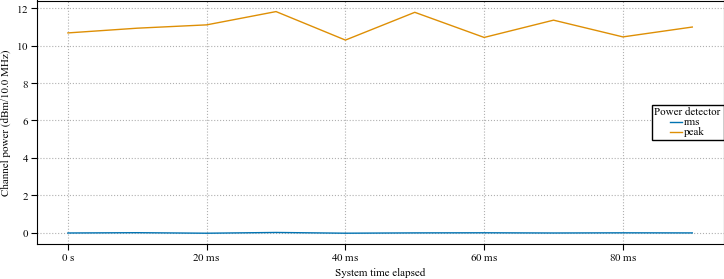

In [14]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from channel_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [15]:
cyclic_power = waveform.cyclic_channel_power(
    iq,
    capture,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
).to_xarray()

In [16]:
def profile():
    return waveform.cyclic_channel_power(
        iq,
        capture,
        cyclic_period=10e-3,
        detector_period=1e-3 / 15 / 4,
        detectors=pvt.power_detector.values,
        cyclic_statistics=('min', 'mean', 'max'),
    )


# benchmark(profile, n_repeat=10)
benchmark(lambda: profile().to_xarray(), n_repeat=10)

<lambda>            :    CPU: 11590.926 us   +/- 2617.228 (min:  7520.042 / max: 17487.989) us     GPU-0: 11891.661 us   +/- 2624.677 (min:  7805.728 / max: 17793.953) us

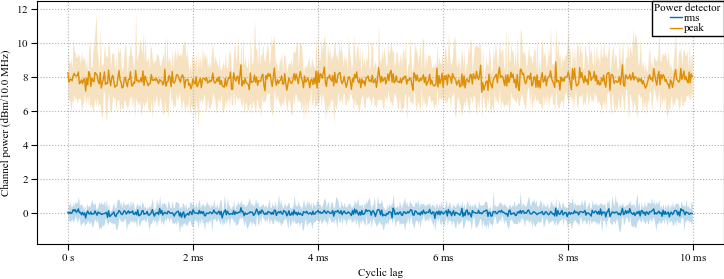

In [17]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Persistence Spectrum

In [19]:
from importlib import reload

waveform = reload(waveform)
waveform.fourier = reload(waveform.fourier)

frequency_resolution = 15e3
spectrum_quantiles = [0.5, 0.75, 0.95, 0.99, 1]

spectrum = waveform.persistence_spectrum(
    iq,
    capture,
    window=('dpss', 5),
    resolution=frequency_resolution,
    statistics=spectrum_quantiles,
    fractional_overlap=0.0,
    truncate=True,
    dB=True,
).to_xarray()

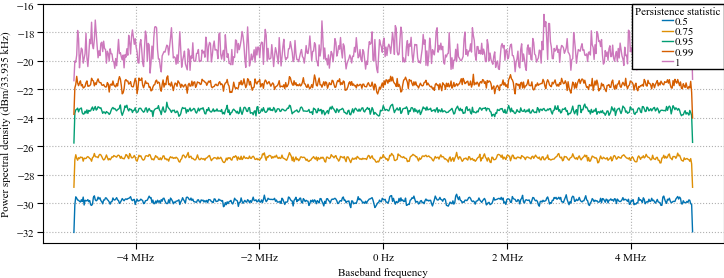

In [20]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')

In [21]:
def profile():
    return waveform.persistence_spectrum(
        iq,
        capture,
        window=('dpss', 3),
        resolution=frequency_resolution,
        statistics=spectrum_quantiles,
        fractional_overlap=0.0,
        truncate=True,
        dB=True,
    )


benchmark(profile, n_repeat=1)
# benchmark(lambda: profile().to_xarray(), n_repeat=10)

# %%timeit -n1 -r1

profile             :    CPU: 51287.327 us     GPU-0: 51336.769 us

### Amplitude Probability Distribution

In [22]:
apd_bins = dict(power_low=-60.0, power_high=15.0, power_count=55 * 4 + 1)

apd = waveform.amplitude_probability_distribution(iq, capture, **apd_bins).to_xarray()

In [23]:
%%timeit -n1 -r1

waveform.amplitude_probability_distribution(iq, capture, **apd_bins).to_xarray()

9.96 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/dkuester/micromamba/envs/flex-spectrum-sensor/lib/python3.9/site-packages/matplotlib/transforms.py:2655: RuntimeWarning: invalid value encountered in scalar multiply
  [0.0    , y_scale, (-inb*y_scale)],


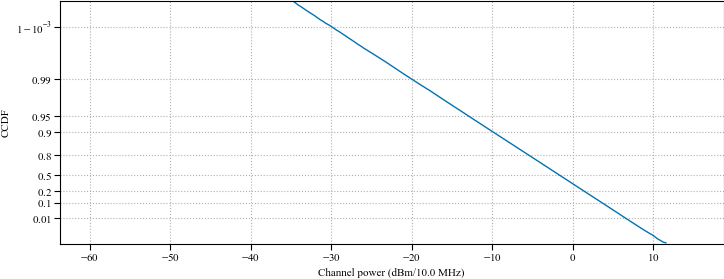

In [24]:
fig, ax = plt.subplots()
apd.plot(ax=ax)

ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

### Putting it all together

In [26]:
# %%timeit -n1 -r1

del iq

iq = source.simulated_awgn(capture, xp=cp, pinned_cuda=True)
iq = source.filter_iq_capture(iq, capture)

analysis_spec = {
    'power_time_series': {'detector_period': 10e-3, 'detectors': ('rms', 'peak')},
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        # 'window': 'flattop',
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
        'resolution': 15e3,
        'statistics': [0.5, 0.75, 0.95, 0.99, 1],
        'truncate': True,
    },
    'amplitude_probability_distribution': {
        'power_low': -40,
        'power_high': 15,
        'power_count': 221,  # 0.25 dB resolution
    },
}

filter_spec = {
    'nfft': 1024,
    'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
}

waveform.analyze_by_spec(iq, capture, spec=analysis_spec)

<xarray.Dataset> Size: 53kB
Dimensions:                             (power_detector: 2, time_elapsed: 10,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         channel_power: 221,
                                         persistence_statistic: 5,
                                         baseband_frequency: 667)
Coordinates:
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 80B 0.0 ... 0.09
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * channel_power                       (channel_power) float32 884B -40.0 .....
  * persistence_statistic               (persistence_statistic) <U4 80B '0.5'...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
Data variables:
    power_time_series                   (power_detector, time_elapsed) float32 80B ...
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float32 14kB ...
    amplitude_probability_distribution  (channel_power) float32 884B 0.9999 ....
    persistence_spectrum                (persistence_statistic, baseband_frequency) float64 27kB ...
Attributes:
    analysis_bandwidth:  10000000.0
    analysis_filter:     {'nfft': 8192, 'window': 'hamming'}
    duration:            0.1
    sample_rate:         15360000.0

In [27]:
def profile():
    return waveform.analyze_by_spec(iq, capture, spec=analysis_spec)


benchmark(profile, n_repeat=2)

profile             :    CPU: 82912.966 us   +/- 967.041 (min: 81945.925 / max: 83880.007) us     GPU-0: 83016.033 us   +/- 971.394 (min: 82044.640 / max: 83987.427) us